# `tutti` tutorial

The purpose of this notebook is to demonstrate how one can use the library `tutti` to get a portfolio allocation with a given alogrithm.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

import tutti
from tutti.data import load_example_data

# Load data

`tutti` is installed with dummy data containing 7 ETF price series (4 equities, 1 bond and 2 commodities, all of them are rebased to start from 1 USD). `tutti` is meant to be *instrument-agnostic* which means users can replace the data with their own assets -- this can be ETFs, stocks, bonds or even trading strategies.

In [2]:
price = load_example_data()

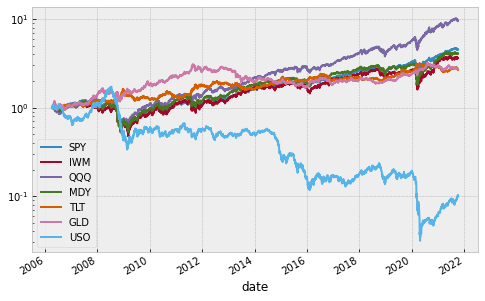

In [3]:
price.plot(logy=True, figsize=(8, 5));

Let's compute weekly returns which we will then use as an input for the weighting methods. The frequency of returns is also up to users. Here weekly is chosen to remove noise.

In [4]:
ret = price.asfreq('w', method='pad').pct_change().dropna()
ret.tail()

,SPY,IWM,QQQ,MDY,TLT,GLD,USO
date,,,,,,,
2021-09-05,0.006285,0.006846,0.014706,-0.002891,-0.007304,0.005112,0.010592
2021-09-12,-0.016862,-0.027812,-0.013051,-0.026634,0.001485,-0.022682,0.002877
2021-09-19,-0.005895,0.003881,-0.007329,-0.003737,0.005189,-0.020397,0.031148
2021-09-26,0.005686,0.005599,-0.000230,0.008769,-0.015150,-0.002870,0.029809
2021-10-03,-0.021784,-0.003452,-0.035224,-0.005232,-0.009363,0.007900,0.027788


# Calculate weights

In this section, we compute optimal weights for some well-known weighting methods. `tutti` natively supports clustering for all weighting methods, however for the sake of simplicity, let's start without clusters (`NoCluster` class).

In [5]:
def plot_weight(weight):
    """ Simple function to plot weights """
    ax = weight.plot(kind='bar')
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
    ax.set_ylabel('Weight')
    ax.set_xlabel('Instrument')

## Mean-variance

In order to compute weights, we need to construct a `Portfolio` instance with instrument returns. 

In [6]:
portfolio = tutti.Portfolio(ret)
portfolio

Portfolio(7 assets)

The `Portfolio` class has a method called `weight_latest` which computes the latest optimal weights using the data that was fed to instantiate the `Portfolio`.

`weight_latest` function needs to receives two arguments:
1. **weighting method**: We use `MeanVariance` class which implements the mean-variance method (aka Markowitz model)
2. **clustering method**: This implements the clusering method to cluter instruments into groups. As mentioned above, we use `NoCluster` here which means there is no clusters.

In [7]:
weight_mv = portfolio.weight_latest(
    tutti.MeanVariance(),
    tutti.NoCluster()
)

It's well known that the mean-variance approach tends to produce extreme outputs. In this example, SPY, IWM, MDY and USO got 0% allocations because of historical lower returns relative to others.

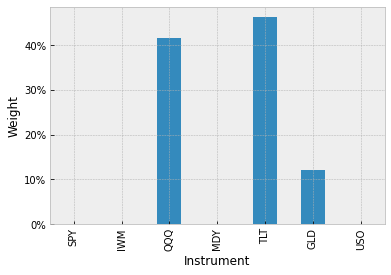

In [8]:
plot_weight(weight_mv)

In [9]:
ret.mean() * 52  # annualised historical returns

SPY    0.115312
IWM    0.112456
QQQ    0.166438
MDY    0.116548
TLT    0.075100
GLD    0.081225
USO   -0.080957
dtype: float64

The portfolio return is computed simply by taking the weighted sum of asset returns.

In [10]:
port_mv = (ret * weight_mv).sum(axis=1)

In the following sections, we try different weighting methods and compare the portfolio's return-risk profile. To use a different weighting method, we just need to replace the `MeanVariance` class with others and the rest should work fine.

## Minimum variance

In [11]:
weight_min_var = portfolio.weight_latest(
    tutti.MinimumVariance(),
    tutti.NoCluster()
)

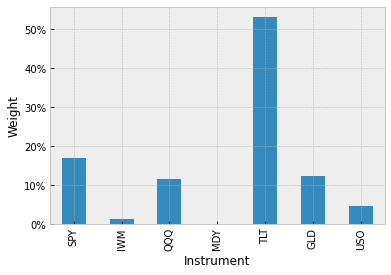

In [12]:
plot_weight(weight_min_var)

In [13]:
port_min_var = (ret * weight_min_var).sum(axis=1)

## Maximum diversification

In [14]:
weight_md = portfolio.weight_latest(
    tutti.MaximumDiversification(),
    tutti.NoCluster()
)

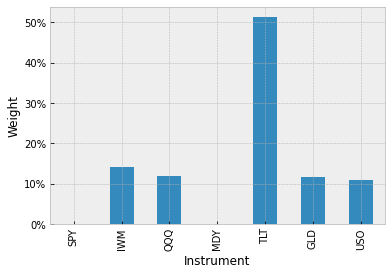

In [15]:
plot_weight(weight_md)

In [16]:
port_md = (ret * weight_md).sum(axis=1)

## Equal risk contribution

In [17]:
weight_erc = portfolio.weight_latest(
    tutti.EqualRiskContribution(),
    tutti.NoCluster()
)

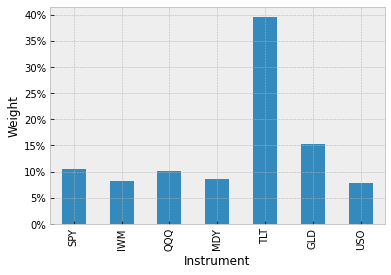

In [18]:
plot_weight(weight_erc)

In [19]:
port_erc = (ret * weight_erc).sum(axis=1)

# Efficient frontier

Now that we got weights with different weighting methods, let's compare them on the mean-variance coordiante. We also plot portfolios with rancomly generated weights to see where the optimised portfolios fall on (or inside) the efficient frontier.

In [20]:
# generate assets weights randomly
n_random = 100_000
weight_random = np.random.rand(n_random, len(ret.columns))
weight_random = weight_random / weight_random.sum(axis=1).reshape(-1, 1)

In [21]:
# randomly generated portfolios
port_ret_random = ret.dot(weight_random.T)

We can see that `MeanVariance` seem to fall on the tangent line, also `MinimumVariance` is located at the peak of the efficient frontier parabola which is also expected.

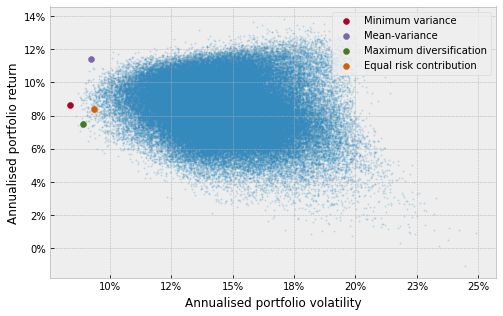

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(port_ret_random.std() * (52 ** 0.5), 
           port_ret_random.mean() * 52,
           s=2, 
           alpha=0.2);
ax.scatter(port_min_var.std() * (52 ** 0.5),
           port_min_var.mean() * 52,
           label='Minimum variance')
ax.scatter(port_mv.std() * (52 ** 0.5),
           port_mv.mean() * 52,
           label='Mean-variance')
ax.scatter(port_md.std() * (52 ** 0.5),
           port_md.mean() * 52,
           label='Maximum diversification')
ax.scatter(port_erc.std() * (52 ** 0.5),
           port_erc.mean() * 52,
           label='Equal risk contribution')
ax.set_xlabel('Annualised portfolio volatility')
ax.set_ylabel('Annualised portfolio return')
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
ax.legend(loc='upper right');

# Clustering

So far we ignored the clutering method and assumed that all assets are somewhat 'different'. However in practice, it's more natural to assume that some assets behave similarly to each other and in that situation, it's more preferable to group those assets into a group and treat as one blob.

As a matter of fact, in the dummy data set we have been using, we have 4 US equity ETFs which are highly correlated (> 90%).

In [23]:
ret.corr()

,SPY,IWM,QQQ,MDY,TLT,GLD,USO
SPY,1.000000,0.911234,0.911042,0.943273,-0.355764,0.058410,0.349839
IWM,0.911234,1.000000,0.837093,0.969620,-0.375628,0.083569,0.337214
QQQ,0.911042,0.837093,1.000000,0.850310,-0.313394,0.034155,0.294755
MDY,0.943273,0.969620,0.850310,1.000000,-0.369113,0.099623,0.357699
TLT,-0.355764,-0.375628,-0.313394,-0.369113,1.000000,0.160022,-0.278164
GLD,0.058410,0.083569,0.034155,0.099623,0.160022,1.000000,0.174914
USO,0.349839,0.337214,0.294755,0.357699,-0.278164,0.174914,1.000000


Let's see what happens if we run `EqualRiskContribution` with a clustering method.

`max_clusters=3` means there can be only up to 3 instruments (or clusters if nested) in a cluster.

In [24]:
weight_erc_cluster = portfolio.weight_latest(
    tutti.EqualRiskContribution(),
    tutti.CorrMatrixDistance(max_clusters=3)
)

The comparison shows that the weight for equities (SPY, IWM and MDY) are pushed down when grouped by clusters.

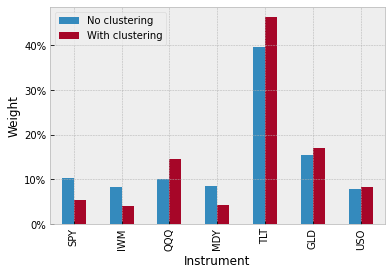

In [25]:
weight_comp = pd.concat((
    weight_erc.rename('No clustering'),
    weight_erc_cluster.rename('With clustering'),
), axis=1)

plot_weight(weight_comp)

In [26]:
weight_comp.loc[['SPY', 'IWM', 'MDY']].sum()

No clustering      0.271884
With clustering    0.138983
dtype: float64

This is because those 3 ETFs are grouped as one cluster, and in fact it's in the second nest level. `cluster_0` can be interpreted as an equity cluster, and inside it there are 2 further clusters -- one contains the 3 ETFs (`cluster_1`), another is just QQQ.

In [27]:
portfolio.create_tree(tutti.CorrMatrixDistance(max_clusters=3)).show()

Node(root)
    Node(cluster_0)
        Node(cluster_1)
            Node(SPY)
            Node(IWM)
            Node(MDY)
        Node(QQQ)
    Node(cluster_2)
        Node(GLD)
        Node(USO)
    Node(TLT)


# Historical allocation

So far we have been using the method `weight_latest` to compute the current weighting given the all return series.

The `Portfolio` class another method called `weight_historical` to apply the calculation on a rolling basis. It can receive two more arguments -- `freq` and `lookback`. `freq` determins the rebalance frequency, and `lookback` determines how many data points up to each rebalance date should be used for the weighting method.

In this tutorial we use monthly rebalancing (`freq='m'`), and 2 year lookback window (`lookback = 52 * 2`).

In [28]:
historical = portfolio.weight_historical(
    tutti.EqualRiskContribution(),
    tutti.CorrMatrixDistance(max_clusters=3),
    freq='m',
    lookback=52 * 2,
)

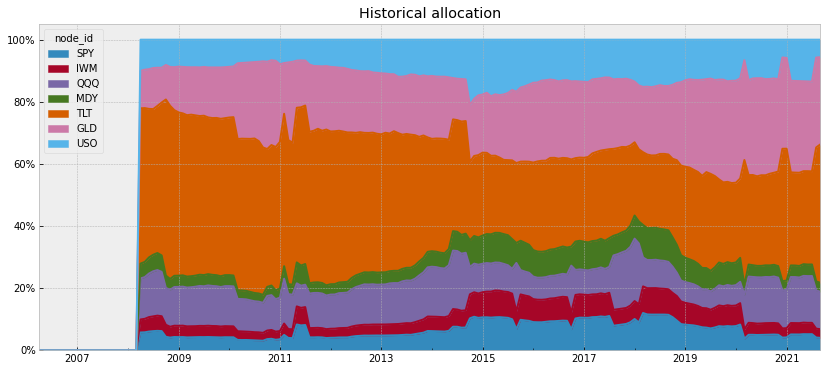

In [29]:
ax = historical.plot(kind='area', figsize=(14, 6))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
ax.set_title('Historical allocation');

# Summary

By now hopefully we see that `tutti` is a modular library and different methods can be applied in a plug-and-play manner. We hope to add more algorithms to the available methods in the future!

Finally, please note that `tutti` is still in **alpha version** which means breaking changes are expected to be added frequently.